# Marin County Habitat Finder

A script tool for creating a weighted sum model with user defined inputs in ArcGIS Pro using portal items. It considers elevation, vegitation height, and vegitation type. In this example we are making a model containing all elevations over 1000 feet, all vegetations between 15 and 25 feet, and all vegetation types that fall into the category 'Forest & Woodland'. Generally, this is the habitat that Black Throated Grey Warbler (BTYW) prefer to breed in. (BTYW is the correct official abbreviation for this bird, if you'd like to know why shoot me an email, or you can just trust me on this one).

This model then outputs a raster with values between 0 and 1 with 0 being no likihood of BTYW breedng, and 1 being a very high likelihood. This model also outputs a maximum liklihood contour around the areas in the raster with the highest values. This model could be adjusted for other species, locations, and more layers could be added to further help refine result.

This tool uses layers loaded from ArcGIS Portal, if you want to run this tool with files from a different area all that is needed are their web item IDs.

Methods covered in this tool are:
* Loading in feature and raster (image service) data from Portal 
* Selecting habitat types, elevation ranges, and vegitation heights as model inputs
* Down sampling to improve run time
* Subtracting DSM and DEM rasters to create vegitation heights
* Building a weighted sum model
* Extracting point data from a raster where the highest probability of a model occurs
* Using point data to create a heatmap and generating contours from it


This notebook is intended to be a companion to the Python script found here: https://github.com/wwiskes/habitatfinder

## Part 1: Loading in the data and selecting desired features
First we load in the libraries we need and set the cell size to something that is more resonable for such a large area.

In [1]:
import arcpy, os, sys, time
from arcpy.sa import *
from arcpy import management as DM
from arcgis.gis import GIS
from arcpy import analysis as AN
from arcpy import conversion as CO
from arcpy import ddd as DDD
arcpy.env.cellSize = 30 # DEMs natively at 1m resolution
arcpy.env.overwriteOutput = True

Next we start a timer by loading in a time stamp, each time we print the time elapsed it simply is just subtracting current time from the previous time stamp. Since we are sending all of the outputs to this script to the same folder that contains it, its nice to print out that location here too.

In [2]:
print("Model running, starting timer")
a = time.perf_counter()/60
env = arcpy.env
script = os.path.dirname(sys.argv[0]) # Script location
print("Script containing folder: " + script)
temp = r"memory"
env.workspace = temp

Model running, starting timer
Script containing folder: C:\Users\User\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages


Loading in the layers using the AcrGIS API. These layers are public so logging into the API is not required.

In [3]:
#Load layers
gis = GIS("https://sfsu.maps.arcgis.com/sharing")
dsm = gis.content.get("b690f8d64d0145f1baf74d73690da154")
dem = gis.content.get("1adaa794cbf2477da2660f190c785fa7")
veg = gis.content.get("6341228ec82a4bfbaf52d977a14e99ce")
b = time.perf_counter()/60
print(f"Layers loaded: {round(b - a, 2)} minutes")

Layers loaded: 0.06 minutes


Next we use Make Feature Layer to convert the API object into something we can run processes on using our local machine. 

In [4]:
#Load vegetation layer
veg2 = veg.layers[0]
veg3 =veg2.url
veg4 = r"memory\veg"
DM.MakeFeatureLayer(veg3, veg4)
c = time.perf_counter()/60
print(f"Veg feature generated: {round(c - b, 2)} minutes")

Veg feature generated: 0.06 minutes


The next three lines of code aren't actually part of the main Py script, however I thought it would be nice for you to see what layers we are working with in this notebook. Here is a vegetation classification feature layer of what is present in Marin County.

In [5]:
vegMap = gis.map('Marin, CA', 10)
vegMap.add_layer(veg)
vegMap

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

Next we select the habitat type we want to look at. This model is looking for BTYW breeding habitat. They prefer woodland so that is what we are selecting here. If you wanted to look at a different habitat check out the list here: http://vegmap.press/lifeform_datasheet

In [6]:
#Select vegitation type 
selection = 'Forest & Woodland' #input variable
where = "LIFEFORM = '" + selection + "'"
DM.SelectLayerByAttribute(veg4, "NEW_SELECTION", where, None)
d = time.perf_counter()/60
print(f"Veg type selected: {round(d - c, 2)} minutes")

Veg type selected: 0.05 minutes


The weighted sum tool needs raster inputs, so next we convert that habitat selection to a conditional raster.

In [7]:
#Make conditional vegitation layer raster
vegCon = r"memory\veg2"
path = script + r"\veg.shp"
CO.FeatureClassToShapefile(veg4, script)
CO.FeatureToRaster(path, "LIFEFORM", vegCon, 30)
e = time.perf_counter()/60
print(f"Veg conditional raster created: {round(e - d, 2)} minutes")

Veg conditional raster created: 1.39 minutes


Now we need to load in our DSM and resample it down from 1m resolution to 30m. This is a long step, it is a very large file we're bringing in from Portal.

In [8]:
#Load non-normalized digital surface model
dsm2 = dsm.layers[0]
dsm3 = dsm2.url
dsm4 = r"memory\dsm"
dsm5 = r"memory\dsm2"
DM.MakeImageServerLayer(dsm3, dsm4)
DM.Resample(dsm4, dsm5, 30)
f = time.perf_counter()/60
print(f"DSM resampled: {round(f - e, 2)} minutes")

DSM resampled: 15.92 minutes


The next three lines of code aren't actually part of the main Py script, however I thought it would be nice for you to see what layers we are working with in this notebook, especially if you may not be familiar with what a DSM is. A DSM is a Digital Surface Model. It contains a 3d representation of everything on the surface of the earth. Look closely at the image shown here, you can clearly see the trees, and the topography of the region as well. 

In [9]:
dsmMap = gis.map('38.0007,-122.7928', 16)
dsmMap.add_layer(dsm)
dsmMap

MapView(layout=Layout(height='400px', width='100%'), zoom=16.0)

Now we need to load in our DEM and resample it down from 1m resolution to 30m. This is also a long step, it is a very large file we're bringing in from Portal.

In [10]:
#Load digital elevation model
dem2 = dem.layers[0]
dem3 = dem2.url
dem4 = r"memory\dem"
dem5 = r"memory\dem2"
DM.MakeImageServerLayer(dem3, dem4)
DM.Resample(dem4, dem5, 30)
g = time.perf_counter()/60
print(f"DEM resampled: {round(g - f, 2)} minutes")

DEM resampled: 16.6 minutes


The next three lines of code aren't actually part of the main Py script, however I thought it would be nice for you to see what layers we are working with in this notebook, especially if you may not be familiar with what a DEM is. A DEM is a Digital Elevation Model. It contains a 3d representation of everything on the surface of the earth, without trees. Look closely at the image shown here, you can clearly see the topography of the region, but the trees have been removed.

In [11]:
demMap = gis.map('38.0007,-122.7928', 16)
demMap.add_layer(dem)
demMap

MapView(layout=Layout(height='400px', width='100%'), zoom=16.0)

What we actually want is the heights of the trees and other vegetation. Notice in the DSM the topography can still be seen. We want to remove that so that we can just look at the heights of the trees. This next step simply subtracts these two rasters effectively removing the landscape from the vegetation. In the image below you can very easily identify where the highest vegetation in Marin county is by the brighter white those areas display. This type of model is called a normalised digital surface model (nDSM).

nDSM generated: 0.03 minutes


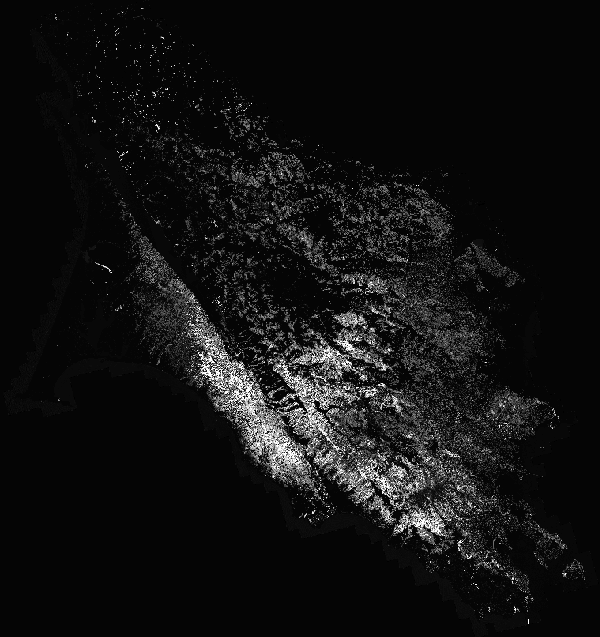

In [12]:
#Normalize surface model
ndsm = Minus(dsm5, dem5)
h = time.perf_counter()/60
print(f"nDSM generated: {round(h - g, 2)} minutes")
ndsm

Next we want to select the values we want to be passed into our model. Here we are selecting all DEM values of between 1000 feet of elevation and 2700 feet (Marin has a maximum height of just under 2700 feet). This is because BTYW prefers a higher elevation for breeding. Here we also select our vegetation heights. BTYW prefers to nest a little bit higher off of the ground in trees over 15 feet, but usually under 25 feet. These values are then used to create new conditional rastes which can be passed into our weighted sum model.

In [13]:
#Conditional values
demValues = [1000, 2700] #1000, 2700
dsmValues = [15, 25] #15, 25 

In [14]:
#Make conditional DEM & DSM layer raster
demCon = Con(dem4, 1, 0, f"VALUE > {demValues[0]} And VALUE < {demValues[1]}")
i = time.perf_counter()/60
print(f"DEM conditional raster created: {round(i - h, 2)} minutes")
dsmCon = Con(ndsm, 1, 0, f"VALUE > {dsmValues[0]} And VALUE < {dsmValues[1]}")
j = time.perf_counter()/60
print(f"DSM conditional raster created: {round(j - i, 2)} minutes")

DEM conditional raster created: 0.55 minutes
DSM conditional raster created: 0.05 minutes


## Part 2: Building the model
Now we have our DEM, nDSM, and vegetation type selected we can put it all together into a model. The first step is to weight our layers, since we are using boolean rasters (1s and 0s) it really doesn't matter too much what weights we give them. However if we wanted to use continous rasters then this is a step we would want to give a lot of thought to. Since we aren't I'm not going to spend too much time on it, but imagine that we didn't just want to know where a habitat is (1s) or isn't (0s), but that we wanted to know how close to a habitat an area is. In that situation we would want to use continous rasters to show the distance away from an area. This would be a great place to expand this model, but is outside the scope of this notebook. 

In [15]:
# Layer Weights, doesn't really effect the model if using 
# boolean rasters like we are now, this model however could use
# continous rasters, in which case these weights would effect model ooutcomes
vegInput = 2
demInput = 1
dsmInput = 1
inList = [vegInput, demInput, dsmInput]
vegProp = vegInput / sum(inList)
demProp = demInput / sum(inList)
dsmProp = dsmInput / sum(inList)

This is the step where we actually execute the weighted sum and save the output. If we look at the output of the model its a little bit difficult to desypher. This is why in the next step we are going to circle the areas of highest BTYW nesting probability using contours. 

Weighted sum complete: 0.02 minutes


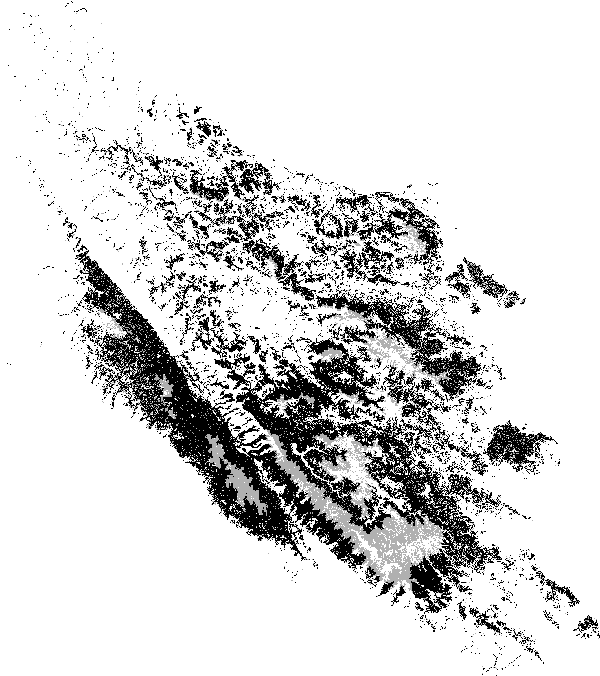

In [16]:
#Make a table of values
myWSTable = WSTable([[vegCon, "VALUE", vegProp], [demCon, "VALUE", demProp], 
                     [dsmCon, "VALUE", dsmProp]])

# Execute WeightedSum
outWeighted = WeightedSum(myWSTable)
# Save the output
output = script + r"/modeloutput"
outWeighted.save(output)
k = time.perf_counter()/60   
print(f"Weighted sum complete: {round(k - j, 2)} minutes")
outWeighted

Here we convert the raster we made in the weighted sum tool into points. This takes every single raster cell and converts it to point data containing the value of each cell. Next we select only those points which have a 90% liklihood of being BTYW breeding habitat. Using those point we can create a kernel density of those habitats. Using this kernel density we can then derive a contour around the areas of highest breeding probability. 

In [17]:
#Make contour around high habitat probability model regions with highest kernel density
points = script + r"\points.shp"
points2 = script + r"\points2.shp"
CO.RasterToPoint(output, points, "Value")
AN.Select(points, points2, "grid_code > 0.9")
kernel = KernelDensity(points2, "NONE", 100, None, "SQUARE_KILOMETERS", "DENSITIES", "PLANAR")
contour = script + r"\contour.shp"
contourOut = DDD.Contour(kernel, contour, 1000, 20, 1, "CONTOUR", None)
l = time.perf_counter()/60   
print(f"Contour complete: {round(l - k, 2)} minutes")

Contour complete: 0.67 minutes


Finally we clean up some files which couldn't be written to memory and print out the locations of the files. The webmap below shows this contour over the weighted sum raster. This tool can be adapted to any user parameters or Portal inputs. Thanks for reading! Check out the webmap here: https://arcg.is/4ib0S0

In [18]:
# Clean things up a bit
if arcpy.Exists(path):
    DM.Delete(path)
if arcpy.Exists(points):
    DM.Delete(points)
if arcpy.Exists(points2):
    DM.Delete(points2)
#All done
print(f"Model complete, total time elapsed: {round(l - a, 2)} minutes")
print("Files located at: " + script)

Model complete, total time elapsed: 35.4 minutes
Files located at: C:\Users\User\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages
